In [34]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline

In [35]:
df = pd.read_csv('../input/Womens Clothing E-Commerce Reviews.csv')

In [36]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [37]:
df.shape

(23486, 11)

In [38]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [39]:
df.dropna(subset=['Review Text'], inplace = True)

In [40]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                13
Department Name              13
Class Name                   13
dtype: int64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 0, 'Age Distribution')

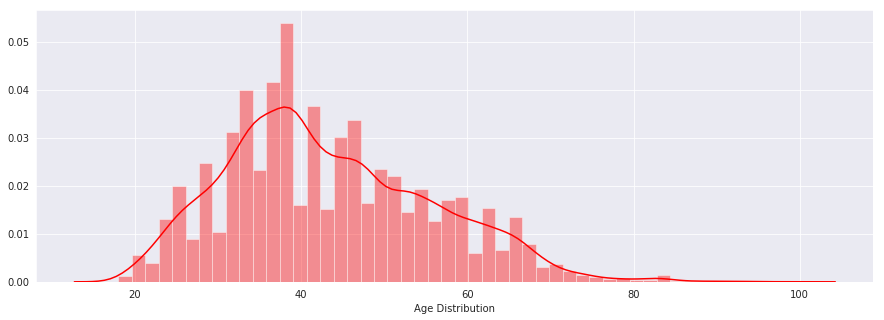

In [41]:
plt.figure(figsize=(15,5))
sns.distplot(df['Age'], bins=50, hist_kws=dict(edgecolor="white", linewidth=1), color='red')
sns.set_style('darkgrid')
plt.xlabel('Age Distribution')

In [42]:
trace = [go.Bar(x=df['Rating'].value_counts().index,
              y=df['Rating'].value_counts().values,
               marker=dict(colorscale='Viridis',
                color = df.Rating.value_counts().values, 
                line=dict(color='rgb(8,48,107)',width=1.5)),
                text='Total Number'
               )]

layout = go.Layout(title='Rating Distribution', width=1000, height=500)
fig = go.Figure(data=trace, layout=layout)
py.iplot(fig)

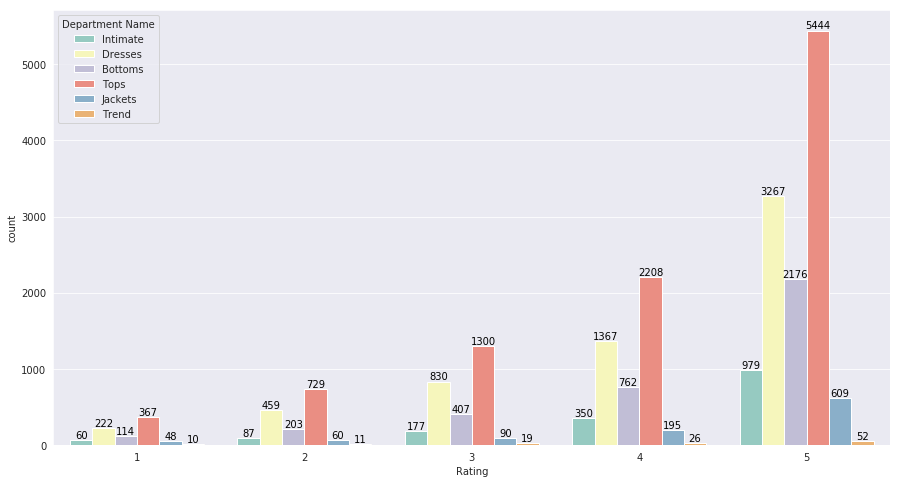

In [43]:
plt.figure(figsize=(15,8))
ax = sns.countplot(df['Rating'], hue=df['Department Name'], palette='Set3')
for p in ax.patches:
     ax.text(p.get_x() + p.get_width()/2., p.get_height(),  '%d' % int(p.get_height()),
            fontsize=10, color='black', ha='center', va='bottom')


**plot the most frequent words**

In [44]:
words = df['Review Text'].str.split(expand=True).unstack().value_counts()
words.head()

the    74698
i      49630
and    48505
a      42632
it     37302
dtype: int64

In [45]:
trace=[go.Bar(
        x=words.index[:51],
        y=words.values[:51], 
        marker= dict(colorscale='Viridis', color = words.values[:51]),
        text='Word counts', 
        )]

layout = go.Layout(title='Top Words Distribution (Before cleaning)', xaxis=dict(tickangle=-45))
fig = go.Figure(data=trace, layout=layout)
py.iplot(fig)

**Cleaning words (Remove Punctuation and Stopwords)**

In [46]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


**Remove Punctuation**

In [47]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [48]:
df['Review Text'] = df['Review Text'].apply(remove_punctuation)

**Remove Stopwords**

In [49]:
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [50]:
df['Review Text'] = df['Review Text'].apply(remove_stopwords)

**Stemming**

In [51]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [52]:
df['Review Text'] = df['Review Text'].apply(stemming)

In [53]:
word = df['Review Text'].str.split(expand=True).stack().value_counts()
word.head()

dress    12061
love     11351
fit      11310
size     10597
look      9276
dtype: int64

In [54]:
trace=[go.Bar(
        x=word.index[:51],
        y=word.values[:51], 
        marker= dict(colorscale='Viridis', color = word.values[:51]),
        text='Word counts', 
        )]

layout = go.Layout(title='Top Words Distribution (After cleaning)', xaxis=dict(tickangle=-45))
fig = go.Figure(data=trace, layout=layout)
py.iplot(fig)

** As we can see, even plotting the top words can't still tell us the overall sentiments of the reviews. We are going to apply SentimentIntensityAnalyzer from nltk library**

**Transform the Rating into two groups, Pos and Neg. We are taking Rating 3 out, which is usually considered netural**

In [55]:
df = df[df['Rating'] != 3]
z = {5: 1, 4:1, 2: 0, 1:0}
df['Rating Senti'] = df['Rating'].map(z)

**Transform the Recommended IND into two groups, Pos and Neg 

**Import SentimentIntensityAnalyzer and create an sid object**


In [56]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [57]:
def review_rating(string):
    scores = sid.polarity_scores(string)
    if scores['compound'] > 0:
        return int('1')
    else:
        return int('0')

In [58]:
df['SID'] = df['Review Text'].apply(review_rating)

In [59]:
df['Rating Senti'].apply(int)
df['Recommended IND'].apply(int)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Rating Senti,SID
0,0,767,33,NaN,absolut wonder silki sexi comfort,4,1,0,Initmates,Intimate,Intimates,1,1
1,1,1080,34,NaN,love dress sooo pretti happen find store im gl...,5,1,4,General,Dresses,Dresses,1,1
3,3,1049,50,My favorite buy!,love love love jumpsuit fun flirti fabul everi...,5,1,0,General Petite,Bottoms,Pants,1,1
4,4,847,47,Flattering shirt,shirt flatter due adjust front tie perfect len...,5,1,6,General,Tops,Blouses,1,1
5,5,1080,49,Not for the very petite,love traci rees dress one petit 5 feet tall us...,2,0,4,General,Dresses,Dresses,0,1


In [60]:
df['Recommended IND'].value_counts()

1    17370
0     2448
Name: Recommended IND, dtype: int64

In [61]:
df['Rating Senti'].value_counts()

1    17448
0     2370
Name: Rating Senti, dtype: int64

**Compare Rating Senti and Recommended IND***

In [62]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(df['Rating Senti'], df['Recommended IND']))
print(classification_report(df['Rating Senti'], df['Recommended IND']))
accuracy_score(df['Rating Senti'], df['Recommended IND'])

[[ 2261   109]
 [  187 17261]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2370
           1       0.99      0.99      0.99     17448

   micro avg       0.99      0.99      0.99     19818
   macro avg       0.96      0.97      0.97     19818
weighted avg       0.99      0.99      0.99     19818



0.9850640831567262

**Compare SID results and Recommended IND**

In [63]:
print(confusion_matrix(df['SID'], df['Recommended IND']))
print(classification_report(df['SID'], df['Recommended IND']))
accuracy_score(df['SID'], df['Recommended IND'])

[[  446   599]
 [ 2002 16771]]
              precision    recall  f1-score   support

           0       0.18      0.43      0.26      1045
           1       0.97      0.89      0.93     18773

   micro avg       0.87      0.87      0.87     19818
   macro avg       0.57      0.66      0.59     19818
weighted avg       0.92      0.87      0.89     19818



0.868755676657584

**Compare SID results and Rating Sentiment**

In [64]:
print(confusion_matrix(df['SID'], df['Rating Senti']))
print(classification_report(df['SID'], df['Rating Senti']))
accuracy_score(df['SID'], df['Rating Senti'])

[[  434   611]
 [ 1936 16837]]
              precision    recall  f1-score   support

           0       0.18      0.42      0.25      1045
           1       0.96      0.90      0.93     18773

   micro avg       0.87      0.87      0.87     19818
   macro avg       0.57      0.66      0.59     19818
weighted avg       0.92      0.87      0.89     19818



0.871480472297911

**Let's explore some other models for better results**

**Logistic Regression

In [72]:
X = df['Review Text']
y = df['Recommended IND']

tfidf = TfidfVectorizer()
X= tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [74]:
model = LogisticRegression()
model.fit(X_train, y_train)
pre1 = model.predict(X_test)
print(classification_report(y_test, pre1))
print(confusion_matrix(y_test, pre1))
accuracy_score(y_test, pre1)

              precision    recall  f1-score   support

           0       0.85      0.40      0.54       804
           1       0.92      0.99      0.95      5736

   micro avg       0.92      0.92      0.92      6540
   macro avg       0.89      0.69      0.75      6540
weighted avg       0.91      0.92      0.90      6540

[[ 319  485]
 [  55 5681]]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



0.9174311926605505

In [75]:
model2 = MultinomialNB()
model2.fit(X_train, y_train)
pre2 = model2.predict(X_test)
print(classification_report(y_test, pre2))
print(confusion_matrix(y_test, pre2))
accuracy_score(y_test, pre2)

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       804
           1       0.88      1.00      0.93      5736

   micro avg       0.88      0.88      0.88      6540
   macro avg       0.94      0.50      0.47      6540
weighted avg       0.89      0.88      0.82      6540

[[   3  801]
 [   0 5736]]


0.8775229357798165

Conclusion: When we look at the evaluating models section, Logistic Regression gives the best results. 